In [1]:
from scipy.optimize import fsolve # Used for solving a system of #K non-linear equations with #K unknows: Used for calibrating the price elastic demand
from scipy.optimize import least_squares
import scipy.interpolate as interpolate
import scipy.stats as stats
# If you experience warning of the type "Future Warning", you can mute them using the following:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

*Import the standard packages and data:*

In [2]:
%run stdPackages.ipynb
slides = False # print to slides format if True
out_folder = os.path.join(d['curr'], 'Misc', 'Figs')
d['data'] = os.path.join(d['curr'],'Misc','Data')
read = {'variables': ['Fundamentals', 'Load', 'Generators_Other'], 
        'variable2D': ['Generators_FuelMix','HourlyVariation'],
        'scalars': ['Scalars'],
        'maps': ['Generators_Categories']}
db = dbFromWB(os.path.join(d['data'],'mBasicInt_StorageExperiment.xlsx'), read)
readSets(db)

# Equilibrium and Welfare Effects of Electricity Storage

Section 1-3 looks at the baseline equilibrium and the characteristics of the bottom-up model

## 1. The Baseline Model

*Start by setting up and solving the model with perfectly inelastic demand:*

In [70]:
m = mBasicInt.mSimple(db.copy())
m.solve()
db_base = m.db.copy()

Solution status 0: Optimization terminated successfully. (HiGHS Status 7: Optimal)


### 1.1. Plot merit order curve for each hour:

*Define functions for making data series for supply and demand:*

In [71]:
def demand_h(m,h):
    return standardPlots.demandLinear_df(m.db['MWP_LoadShedding'], m.hourlyLoad.xs(h))
def supply_h(m,h,maxY=30):
    return standardPlots.meritOrderCurve_df(m.db['mc'], m.hourlyGeneratingCapacity.xs(h,level='h'),maxY=maxY)

*Now make the plot:*

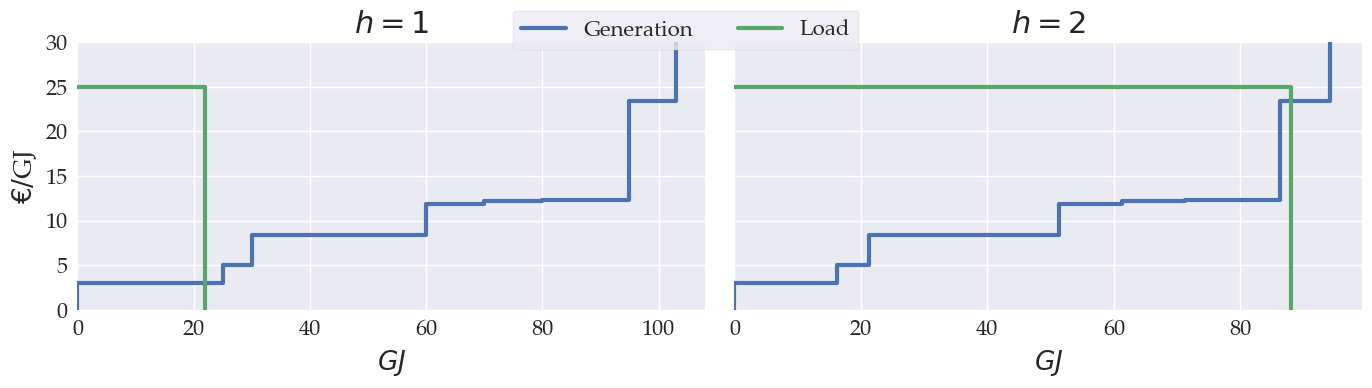

In [64]:
# %%capture
mult_graphs()
nplots = len(m.db['h'])
nrows = math.ceil(nplots/2)
fig,axes = plt.subplots(nrows,min(nplots,2),figsize=(14,(4*nrows)),sharey=True);
plt.subplots_adjust(hspace=0.35)
offset_N, offset_Arrow, offset_q = 1, 1, 3
for j in range(nplots):
    ax = plt.subplot(nrows,min(nplots,2),j+1)
    h = j+1
    df = supply_h(m,h)
    dh = demand_h(m,h)
    
    df.plot(linewidth=3,ax=ax,legend=False);
    dh.plot(linewidth=3,ax=ax,legend=False);
    ax.set_xlabel(r'$GJ$', labelpad = 5);
    ax.set_ylabel(r'$€/$GJ', labelpad = 5);
    ax.set_xlim([0, max([dh.index.max(), df.index.max()])+5]);
    ax.set_ylim([0, math.ceil(max([df.max()[0], dh.max()[0]]))]);
    ax.set_title(f"""$h={h}$""")
    
    
fig.legend(['Generation', 'Load'],loc=9,ncol=2,frameon=True)
fig.tight_layout();
fig.subplots_adjust(top=0.9);
if slides:
    fig.savefig(f"{out_folder}\\mBasicInt_Storage_MeritOrder_slides.pdf",facecolor='#FAFAFA',edgecolor='k')
else:
    fig.savefig(f"{out_folder}\\mBasicInt_Storage_MeritOrder.pdf",edgecolor='k')

### 1.2. Plot marginal fuel consumption and CO2 emissions for each hour:

*Functions for making database:*

In [65]:
def other_from_supply(h,mc,production,other):
    production = production.xs(h,level='h')
    df = pd.concat({**{'c':mc,'q':production},**{x:other[x] for x in other.columns}},axis=1).sort_values(by='c').drop(columns='c')
    df = df[df['q']>0]
    df['q'] = df['q'].cumsum()
    df_up = df.copy()
    df_up['q'] = df_up['q']+np.finfo(float).eps
    df_up[other.columns.values] = df_up[other.columns.values].shift(-1)
    df = df.append(df_up.dropna()).sort_values('q').set_index('q')
    df.loc[0] = [0]*len(other.columns)
    return df.sort_index()

def other_from_prices(h,mc,production,other):
    production = production.xs(h,level='h')
    df = pd.concat({**{'c':mc,'q':production},**{x:other[x] for x in other.columns}},axis=1).sort_values(by='c').drop(columns='q')
    df_up = df.copy()
    df_up['c'] = df_up['c']+np.finfo(float).eps
    df_up[other.columns.values] = df_up[other.columns.values].shift(-1)
    df = df.append(df_up.dropna()).sort_values('c').set_index('c')
    df.loc[0] = [0]*len(other.columns)
    return df.sort_index()

*Plot marginal emissions:*

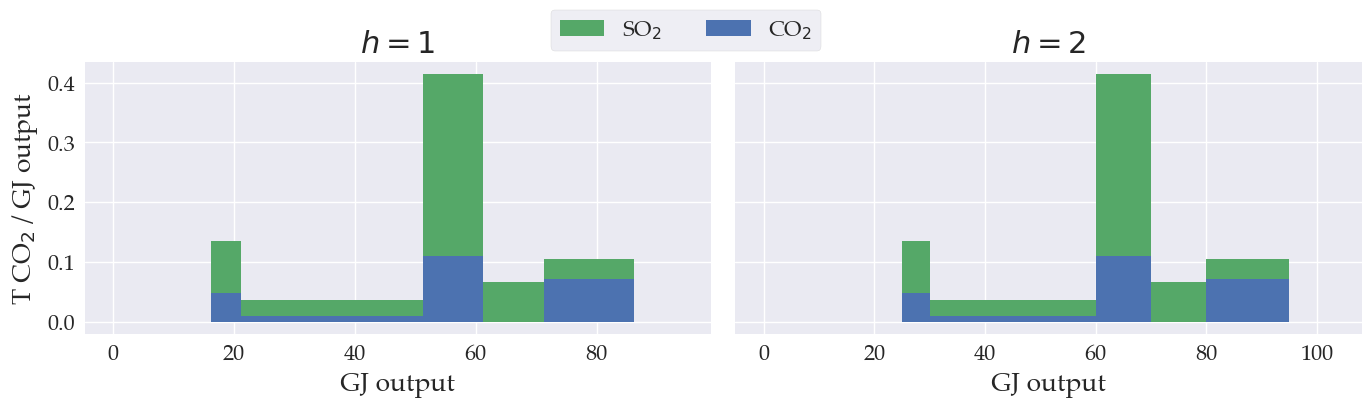

In [67]:
mult_graphs()
nplots = len(m.db['h'])
nrows = math.ceil(nplots/2)
fig,axes = plt.subplots(nrows,min(nplots,2),figsize=(14,(4*nrows)),sharey=True);
plt.subplots_adjust(hspace=0.35)
offset_N, offset_Arrow, offset_q = 1, 1, 3
for j in range(nplots):
    ax = plt.subplot(nrows,min(nplots,2),j+1)
    df = other_from_supply(h=h,mc=m.db['mc'],production=m.hourlyGeneratingCapacity,other= mBasicInt.plantEmissionIntensity(m.db).unstack('EmissionType'))
    h = j+1
    
    df.plot(kind='area',linewidth=0,ax=ax,legend=False,stacked=True);
    ax.set_ylabel(r'T CO$_2$ / GJ output', labelpad = 5);
    ax.set_xlabel(r'GJ output', labelpad = 5);
    ax.set_title(f"""$h={h}$""")

legend_elements = [mpl.patches.Patch(facecolor=colors[1], edgecolor=None, label='SO$_2$'),
                   mpl.patches.Patch(facecolor=colors[0], edgecolor=None, label='CO$_2$')]
fig.legend(handles=legend_elements, loc='lower center', ncol=4, frameon=True, bbox_to_anchor=(0.5, 0.9))
fig.tight_layout();
fig.subplots_adjust(top=0.9);
if slides:
    fig.savefig(f"{out_folder}\\mBasicInt_Storage_Emissions_slides.pdf",facecolor='#FAFAFA',edgecolor='k')
else:
    fig.savefig(f"{out_folder}\\mBasicInt_Storage_Emissions.pdf",edgecolor='k')

*Plot marginal fuel conumpstion:*

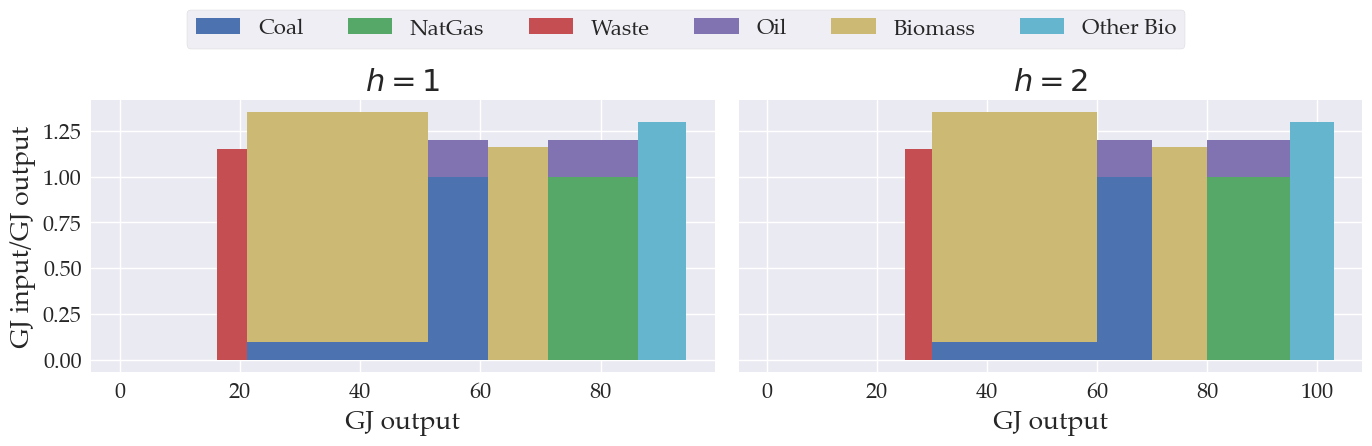

In [69]:
mult_graphs()
nplots = len(m.db['h'])
nrows = math.ceil(nplots/2)
fig,axes = plt.subplots(nrows,min(nplots,2),figsize=(14,(4*nrows)),sharey=True);
plt.subplots_adjust(hspace=0.35)
offset_N, offset_Arrow, offset_q = 1, 1, 3
for j in range(nplots):
    ax = plt.subplot(nrows,min(nplots,2),j+1)
    df = other_from_supply(h=h,mc=m.db['mc'],production=m.hourlyGeneratingCapacity,other= m.db['FuelMix'].unstack('BFt'))
    # df = other_from_prices(h=h,mc=m.db['mc'],production=m.hourlyGeneratingCapacity,other= m.db['FuelMix'].unstack('BFt'))
    agg_cols = {'Oil':['Fueloil','Gasoil'], 'Biomass':['Straw','WoodPellets','WoodChips','WoodWaste'],'Other Bio':['Biogas','BioOil']}
    for col in agg_cols.keys():
        df[col] = df[agg_cols[col]].sum(axis=1)
    df.drop(columns=[item for sublist in list(agg_cols.values()) for item in sublist],inplace=True) 

    h = j+1
    
    df.plot(kind='area',linewidth=0,ax=ax,legend=False,stacked=True);
    ax.set_ylabel(r'GJ input/GJ output', labelpad = 5);
    ax.set_xlabel(r'GJ output', labelpad = 5);
    # ax.set_xlim([0, max([dh.index.max(), df.index.max()])+5]);
    # ax.set_ylim([0, math.ceil(max([df.max()[0], dh.max()[0]]))]);
    ax.set_title(f"""$h={h}$""")

# fig.legend(['CO$_2$', 'SO$_2$'],loc=9,ncol=2,frameon=True)
fuels = df.columns
legend_elements = [mpl.patches.Patch(facecolor=colors[x], edgecolor=None, label=fuels[x]) for x in range(len(fuels))]
fig.legend(handles=legend_elements, loc='lower center', ncol=len(fuels), frameon=True, bbox_to_anchor=(0.5, 1))
fig.tight_layout();
fig.subplots_adjust(top=0.9);
if slides:
    fig.savefig(f"{out_folder}\\mBasicInt_Storage_FuelConsumption_slides.pdf",facecolor='#FAFAFA',edgecolor='k')
else:
    fig.savefig(f"{out_folder}\\mBasicInt_Storage_FuelConsumption.pdf",edgecolor='k')

## 2. Introduce Price Elastic Demand

*Get the basic parameters of the baseline model:*

In [72]:
pj_ini = m.db['marginalSystemCosts'].values # Hourly prices
E_ini = m.db['Load'].astype(float).values[0] # Yearly demand
Ej_ini = m.db['LoadVariation'].astype(float).values*E_ini # Hourly demand
I = sum(Ej_ini*pj_ini) # Total expenditures=Income
Exp = sum(m.db['HourlyDemand'].values*pj_ini)
p_ini = I/E_ini # Iniatal yearly price index
λ = 0.2 # Storage loss

*Create loop on storage level:*

In [10]:
# Loop length
loop = pd.Index(range(10), name = 'loop')

# Off-peak grid
v0 = pd.Series(db['LoadVariation'].min(), index = pd.Index(['c1'], name = 'c')) # 'id4' is the wind plant
vT = pd.Series(0.40, index = pd.Index(['c1'], name = 'c'))
OffPeakGrid = addGrid(v0, vT, loop, 'LoadVariation')# inputs are (1) first value in grid, (2) final value, (3) loop, (4) name of symbol
OffPeakGrid.index = pd.MultiIndex.from_tuples([(a[0],a[1],1) for a in OffPeakGrid.index], names=OffPeakGrid.index.names+['h'])

# Peak grid
step = OffPeakGrid.diff().fillna(0)
S0_grid = (step.cumsum()*db['Load']).astype(float).values
PeakGrid = pd.Series([db['LoadVariation'].max()-(1-λ)*s[-1]*s[0][0] for s in step.iteritems()],index=OffPeakGrid.rename({1:2},level='h').index,name='LoadVariation').sort_index()

# Common grid
LoadVariationGrid = OffPeakGrid.append(PeakGrid).sort_index()

*Specify non-linear model:*

In [11]:
def smooth_supply(p,*params):
    mc,q,σ_s = params
    return (q*stats.norm.cdf((p[:,np.newaxis]-mc)/σ_s)).sum(axis=1)
def p_index(p,*params):
    μ,σ_d = params
    if σ_d!=1:
        return (μ*p**(1-σ_d)).sum(axis=0)**(1/(1-σ_d))
    else:
        return ((p/μ)**(μ)).prod(axis=0)
def demand(p,*params):
    μ,σ_d,I = params
    p_i = p_index(p,*(μ,σ_d))
    return μ*(p/p_i)**(-σ_d)*I/p_i
def excess_supply(p,*params):
    mc,q,σ_s,μ,σ_d,I,S0,λ = params
    S = smooth_supply(p,*(mc,q,σ_s))
    D = demand(p,*(μ,σ_d,I))
    return (S[0]-D[0]-S0,S[1]-D[1]+(1-λ)*S0)

*Define how to search for cornor solutions (i.e. vertical lines on the supply curve)*

In [12]:
def solve_for_demand(x,*params):
    μ,σ_d,I,p,D,state=params
    if state==1:
        return(
            x[0] - μ[0]*(p/x[2])**(-σ_d)*I/x[2],
            D - μ[1]*(x[1]/x[2])**(-σ_d)*I/x[2],
            x[2] - p_index(np.array([p,x[1]]),*(μ,σ_d))
        )
    if state==0:
        return(
            D - μ[0]*(x[1]/x[2])**(-σ_d)*I/x[2],
            x[0] - μ[1]*(x[1]/x[2])**(-σ_d)*I/x[2],
            x[2] - p_index(np.array([p,x[1]]),*(μ,σ_d))
        )
    if state=='both':
        return(
            D[0] - μ[0]*(x[0]/x[2])**(-σ_d)*I/x[2],
            D[1] - μ[1]*(x[1]/x[2])**(-σ_d)*I/x[2],
            x[2] - p_index(np.array([x[0],x[1]]),*(μ,σ_d))
        )

*Define what to extract from the LP model:*

In [13]:
def extract_from_LPmodel(m,demand,p,σ_d,S0):
    
    p = pd.Series(p,index=m.db['marginalSystemCosts'].index,name=m.db['marginalSystemCosts'].name)
    # a) Update demand for linear model:
    S_NLmodel = demand + np.array([S0,-(1-λ)*S0])
    TotSupply = sum(S_NLmodel)
    m.db['Load'] = pd.Series([TotSupply],index=m.db['Load'].index,name='Load')
    m.db['HourlyDemand'] = pd.Series(S_NLmodel,index=m.db['HourlyDemand'].index,name='HourlyDemand')
    m.db['LoadVariation'] = pd.Series(m.db['HourlyDemand'].values/m.db['Load'].sum(),index=m.db['LoadVariation'].index,name='LoadVariation')

    # b) Solve linear programming model:
    m.solve(printSol=False);
    
    # c) Extract
    Generation = m.db['Generation'].groupby('id').agg('sum')
    PracticalCapFactor = (Generation/m.hourlyGeneratingCapacity.groupby('id').agg('sum').replace(0,np.inf))
    FOM = m.db['FOM']*1000*len(m.db['h'])/8760
    marginalEconomicValue = (p*m.db['Generation']-m.db['mc']*m.db['Generation']-FOM*m.db['Generation']/m.db['Generation'].replace(0,np.inf)).groupby('id').agg('sum')
    id2tech = {x[0]:x[1] for x in db['id2tech']}
    Profits = (p*m.db['Generation']-m.db['mc']*m.db['Generation']).groupby('id').agg('sum')
    out = pd.concat({
        'Generation':Generation,'PracticalCapacityFactor':PracticalCapFactor,'marginalEconomicValue':marginalEconomicValue,
        'Profits':Profits
    },axis=1).rename(id2tech,level='id').astype(float)
    out = out.groupby(['id']).agg({x:'sum' if x!='PracticalCapacityFactor' else 'mean' for x in out.columns}).rename_axis(['Agent'])
    out.index = pd.MultiIndex.from_tuples([(σ_d,S0,x) for x in out.index],names=['$\sigma_d$','S$_0$','Agent'])
    return out

*Plot smooth supply:*

In [14]:
p_grid = np.linspace(0.1,m.db['MWP_LoadShedding']*1.5,endpoint=True,num=99)
p1 = np.sort(np.append(p_grid,np.array([pj_ini[0]])))
p2 = np.sort(np.append(p_grid,np.array([pj_ini[1]])))
p = np.array([p1,p2]).reshape(2,100)
# Calibrate CES parameters by normalizing price index to 1:
σ_d = 0
μ = Ej_ini*pj_ini**σ_d/I

# Update flexible demand
E1 = [demand(np.array([p,pj_ini[1]]),*(μ,σ_d,I))[0] for p in p1]
E2 = [demand(np.array([pj_ini[0],p]),*(μ,σ_d,I))[1] for p in p2]
E = np.array([E1,E2]).reshape(2,100)

# Supply
mc = m.db['mc'].astype(float).sort_index().values.reshape(1,len(m.db['mc']))
q = m.hourlyGeneratingCapacity.unstack('id').sort_index().astype(float).values
q_max = q.sum(axis=1)
df_kink = pd.concat({'p':m.db['mc'].astype(float),'q':m.hourlyGeneratingCapacity.unstack('h').astype(float)},axis=1)
df_kink.columns = ['p',1,2]
df_kink = df_kink.groupby('p').agg('sum').reset_index()
df_kink = df_kink.sort_values('p')
df_kink[[1,2]] = df_kink[[1,2]].cumsum()
df_kink['p_up'] = df_kink['p'].shift(-1)
df_kink['1_down'] = df_kink[1].shift(1).fillna(0)
df_kink['2_down'] = df_kink[2].shift(1).fillna(0)
df_kink.iloc[len(df_kink)-1,3] = m.db['MWP_LoadShedding']

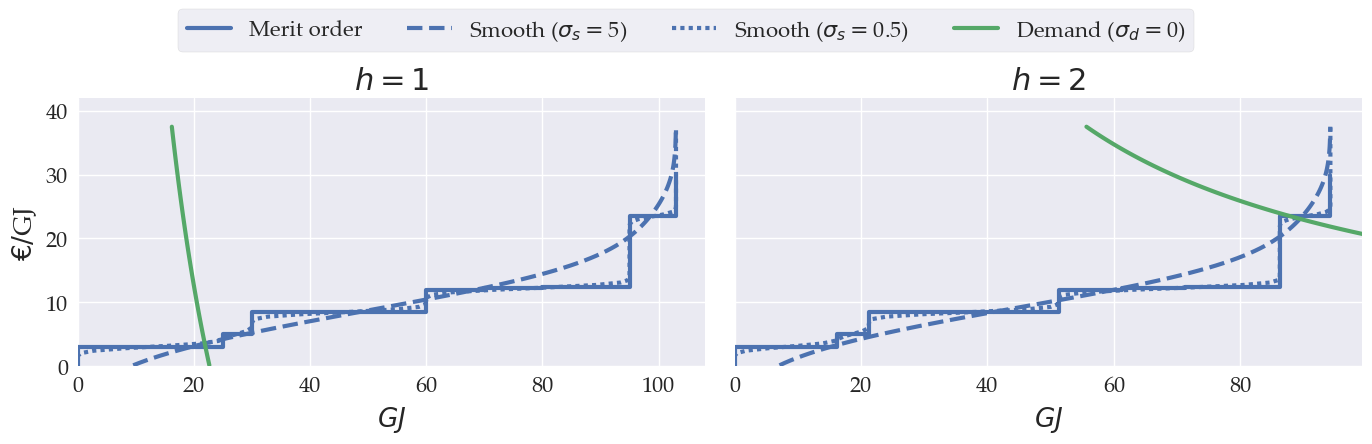

In [15]:
# %%capture
mult_graphs()
nplots = len(m.db['h'])
nrows = math.ceil(nplots/2)
fig,axes = plt.subplots(nrows,min(nplots,2),figsize=(14,(4*nrows)),sharey=True);
plt.subplots_adjust(hspace=0.35)
offset_N, offset_Arrow, offset_q = 1, 1, 3
for j in range(nplots):
    ax = plt.subplot(nrows,min(nplots,2),j+1)
    h = j+1
    df = supply_h(m,h)
    
    df.plot(linewidth=3,ax=ax,legend=False,color=colors[0]);
    lst = ['--',(0,(1,1))]
    σ_s_grid = [5,0.5]
    for i in range(len(σ_s_grid)):
        σ_s = σ_s_grid[i]
        S = np.array([smooth_supply(np.array([p1,p2]),*(mc,q,σ_s)) for p1,p2 in zip(p1,p2)])
        ax.plot(S[:,j],p[j],linewidth=3,color=colors[0],linestyle=lst[i]);
    ax.plot(E[j],p[j],linewidth=3,color=colors[1]);
    ax.set_xlabel(r'$GJ$', labelpad = 5);
    ax.set_ylabel(r'$€/$GJ', labelpad = 5);
    ax.set_xlim([0, max([dh.index.max(), df.index.max()])+5]);
    ax.set_ylim([0, math.ceil(p_grid.max()*1.1)]);
    ax.set_title(f"""$h={h}$""")
    
    
fig.legend(['Merit order', r'Smooth ($\sigma_s=$'+str(σ_s_grid[0])+')',r'Smooth ($\sigma_s=$'+str(σ_s_grid[1])+')',r'Demand ($\sigma_d=$'+str(σ_d)+')'],loc=9,ncol=4,frameon=True,bbox_to_anchor=(0.5, 1.15))
fig.tight_layout();
fig.subplots_adjust(top=0.9);
if slides:
    fig.savefig(f"{out_folder}\\mBasicInt_Storage_SmoothMeritOrder_slides.pdf",facecolor='#FAFAFA',edgecolor='k')
else:
    fig.savefig(f"{out_folder}\\mBasicInt_Storage_SmoothMeritOrder.pdf",edgecolor='k')

*Specify iterative solution algorithm:*

In [16]:
def simple_iterations(ϵ,max_iter,params): # ϵ is the absolute error allowed
    
    # Book-keeping
    n_iter = 0
    Obj = 10

    # Unpack parameters:
    mc,q,μ,σ_d,I,S0,λ,p_tmp= params
    
    while (Obj>=ϵ) & (n_iter<=max_iter):    
        
        # b) Update demand for linear model:
        D = demand(p_tmp,*(μ,σ_d,I))
        S_NLmodel = D + np.array([S0,-(1-λ)*S0])
        TotSupply = sum(S_NLmodel)
        m.db['Load'] = pd.Series([TotSupply],index=m.db['Load'].index,name='Load')
        m.db['HourlyDemand'] = pd.Series(S_NLmodel,index=m.db['HourlyDemand'].index,name='HourlyDemand')
        m.db['LoadVariation'] = pd.Series(m.db['HourlyDemand'].values/m.db['Load'].sum(),index=m.db['LoadVariation'].index,name='LoadVariation')
        
        # b) Solve linear programming model:
        m.solve(printSol=False);

        # c) Get results from linear programming model:
        p_tmp = m.db['marginalSystemCosts'].values
        D_LPmodel = m.db['HourlyDemand'].values - np.array([S0,-(1-λ)*S0])
        p_LPmodel = p_tmp.copy()
                
       
        # Update on demand using LP prices
        D_NLmodel = demand(p_LPmodel,*(μ,σ_d,I))
        
        # e) Check condition:
        Obj = ((D_NLmodel-D_LPmodel)**2).sum()
        
        # Update number of iterations and continue:
        n_iter += 1
    
    # Return object when finished
    df_plant = extract_from_LPmodel(m,D,p_tmp,σ_d,S0)
    
    return (p_tmp,p_index(p_tmp,*(μ,σ_d)),D_NLmodel, D_NLmodel + np.array([S0,-(1-λ)*S0]),df_plant,Obj)

In [17]:
def calib_CobbDouglas(μ,*params):
    p,I,D = params
    return(
        D[0] - μ[0]*I/p[0],
        D[1] - μ[1]*I/p[1],
        1 - (p**(μ)).prod(axis=0)
    )

*Solve model in nested for-loops:*

In [58]:
σ_grid = [0,0.5,1,1.5,5]
CES_param = {}
solution = {}
df_results = pd.DataFrame()
df_plants = pd.DataFrame()
for σ_d in σ_grid:
    print(σ_d)
    
    # Calibrate CES parameters by normalizing price index to 1:
    p_tmp = pj_ini.copy()
    μ = Ej_ini*pj_ini**σ_d/I

    # Restart model
    m.db = db_base.copy()
    
    solution[σ_d] = {}
        
    for S0 in S0_grid:
        index = pd.MultiIndex.from_tuples([(σ_d,S0,h) for h in [1,2]],names=['$\sigma_d$','S$_0$','h'])
        # Solve NonLinear programming model:
        for σ_s in [1,0.5,0.25,0.1,0.05,0.01,0.005]:
            p_tmp = fsolve(excess_supply,x0=p_tmp,args=(mc,q,σ_s,μ,σ_d,I,S0,λ))
        p_NLmodel = p_tmp.copy()
        D_NLmodel = demand(p_tmp,*(μ,σ_d,I))
        S_NLmodel = smooth_supply(p_tmp,*(mc,q,σ_s))
        
        # Define supply curve
        df_tmp = df_kink.copy()
        
        # Check wether we have a marginal plant
        atol = (df_tmp['p']-df_tmp['p'].shift()).nsmallest(2).max()
        p1_con, p2_con = np.isclose(df_tmp['p'],p_tmp[0],atol=atol/10), np.isclose(df_tmp['p'],p_tmp[1],atol=atol/10)
        if (p1_con.sum()>0) & (p2_con.sum()>0):
            p_tmp,p_t,D,S,df_plant,Obj = simple_iterations(ϵ=0.01,max_iter=10,params=(mc,q,μ,σ_d,I,S0,λ,p_tmp))
            if Obj>0.01:
                print('Error 1: '+str(S0))
        elif (p1_con.sum()>0) & (p2_con.sum()==0):
            cond = np.isclose(df_tmp[2],S_NLmodel[1],atol=1)
            D2 = df_tmp[2][cond].values[0]+(1-λ)*S0
            p1 = df_tmp.loc[p1_con,'p'].values[0]
            p2_range = [df_tmp.loc[cond,'p'].values[0],df_tmp.loc[cond,'p_up'].values[0]]
            D1_range = [x-S0 for x in [df_tmp.loc[p1_con,'1_down'].values[0],df_tmp.loc[p1_con,1].values[0]]]
            D1, p2,_ = fsolve(solve_for_demand, x0=[D_NLmodel[0],p_NLmodel[1],p_index(p_NLmodel,*(μ,σ_d))],args=(μ,σ_d,I,p1,D2,1))
            res = least_squares(
                fun = solve_for_demand,
                x0=[D_NLmodel[0],p_NLmodel[1],p_index(p_NLmodel,*(μ,σ_d))],
                bounds = ((D1_range[0], p2_range[0],-np.inf), (D1_range[1], p2_range[1],np.inf)),
                args=(μ,σ_d,I,p1,D2,1)
                )['x']
            D1, p2, = res[0],res[1]
            if (p2_range[0]<=p2<=p2_range[1]) & (D1_range[0]<=D1<=D1_range[1]):
                p_tmp = np.array([p1,p2])
                D = np.array([D1,D2])
                S = D+np.array([S0,-(1-λ)*S0])
                p_t = p_index(p_tmp,*(μ,σ_d))
                df_plant = extract_from_LPmodel(m,D,p_tmp,σ_d,S0)
            else:
                print('Error 2: '+str(S0))
        elif (p1_con.sum()==0) & (p2_con.sum()>0):
            cond = np.isclose(df_tmp[1],S_NLmodel[0],atol=1)
            D1 = df_tmp[1][cond].values[0]-S0
            p2 = df_tmp.loc[p2_con,'p'].values[0]
            p1_range = [df_tmp.loc[cond,'p'].values[0],df_tmp.loc[cond,'p_up'].values[0]]
            D2_range = [x+(1-λ)*S0 for x in [df_tmp.loc[p2_con,'2_down'].values[0],df_tmp.loc[p2_con,2].values[0]]]
            D2, p1,_ = fsolve(solve_for_demand, x0=[D_NLmodel[1],p_NLmodel[0],p_index(p_NLmodel,*(μ,σ_d))],args=(μ,σ_d,I,p2,D1,0))
            if (p1_range[0]<=p1<=p1_range[1]) & (D2_range[0]<=D2<=D2_range[1]):
                p_tmp = np.array([p1,p2])
                D = np.array([D1,D2])
                S = D+np.array([S0,-(1-λ)*S0])
                p_t = p_index(p_tmp,*(μ,σ_d))
                df_plant = extract_from_LPmodel(m,D,p_tmp,σ_d,S0)
            else:
                print('Error 3: '+str(S0))
        elif (p1_con.sum()==0) & (p2_con.sum()==0):
            cond1 = np.isclose(df_tmp[1],S_NLmodel[0],atol=1)
            cond2 = np.isclose(df_tmp[2],S_NLmodel[1],atol=1)
            D1 = df_tmp[1][cond1].values[0]-S0
            D2 = df_tmp[2][cond2].values[0]+(1-λ)*S0
            p1_range = [df_tmp.loc[cond1,'p'].values[0],df_tmp.loc[cond1,'p_up'].values[0]]
            p2_range = [df_tmp.loc[cond2,'p'].values[0],df_tmp.loc[cond2,'p_up'].values[0]]
            p1, p2,_ = fsolve(solve_for_demand, x0=[p_NLmodel[0],p_NLmodel[1],p_index(p_NLmodel,*(μ,σ_d))],args=(μ,σ_d,I,None,[D1,D2],'both'))
            if (p1_range[0]<=p1<=p1_range[1]) & (p2_range[0]<=p2<=p2_range[1]):
                p_tmp = np.array([p1,p2])
                D = np.array([D1,D2])
                S = D+np.array([S0,-(1-λ)*S0])
                p_t = p_index(p_tmp,*(μ,σ_d))
                df_plant = extract_from_LPmodel(m,D,p_tmp,σ_d,S0)
            else:
                print('Error 4: '+str(S0))
        if (1-λ)*p_tmp[1]>=p_tmp[0]:
            df_r_tmp = pd.concat([pd.Series(p_tmp,index=index,name='p'),pd.Series([p_t,p_t],index=index,name='p_index'),pd.Series(D,index=index,name='D'),pd.Series(S,index=index,name='S')],axis=1)
            df_results = df_results.append(df_r_tmp)
            df_plants = df_plants.append(df_plant)

0
0.5
1
1.5
5


*Change labels:*

In [59]:
σ_d_labels = {
    0:'Perfect Complements ($\sigma_d=$0)',
    0.5:'Gross Complements ($\sigma_d=$0.5)',
    1:'Cobb-Douglas ($\sigma_d=$1)',
    1.5:'Gross Substitutes ($\sigma_d=2)',
    10: 'High Substitutes ($\sigma_d=5)',
}
df_plants = df_plants.rename(σ_d_labels,level='$\sigma_d$')

#### 4.1. *Simulate experiment:*

To create the simulation, we use the ```loopSolveExtract``` method that we also used in [Exercise 1](E1_SolutionGuide.ipynb):

i) Create loop (with 51 gridpoints here):

iii) Specify which symbols to save in the simulations:

In [19]:
extract = ['Generation','marginalEconomicValue','marginalSystemCosts','LoadVariation','HourlyDemand','Welfare']

iv) Run simulation:

In [20]:
solution = m.loopSolveExtract(loop,[LoadVariationGrid],extract)

*Plot prices:*

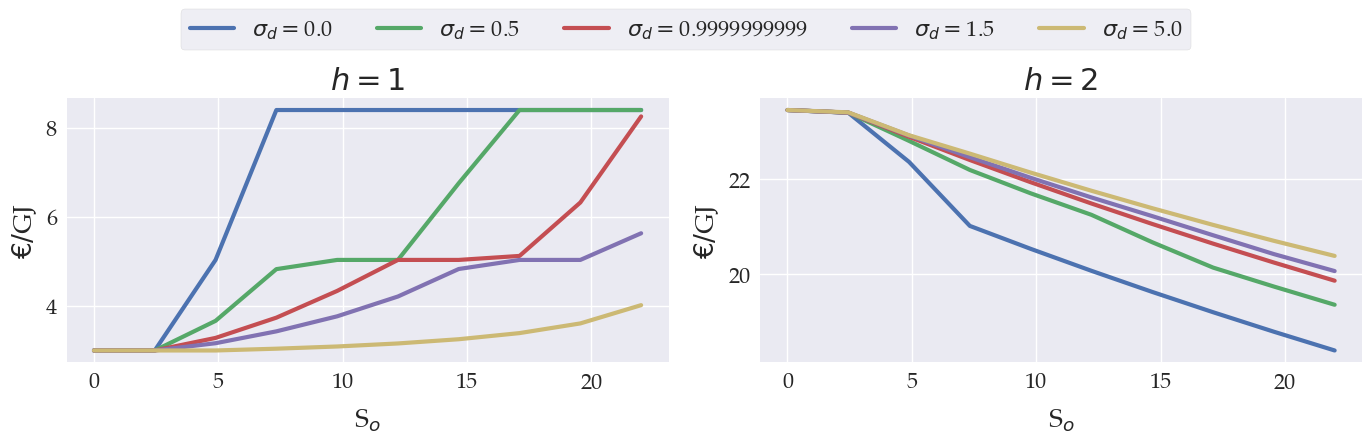

In [21]:
# %%capture
mult_graphs()
nplots = len(m.db['h'])
nrows = math.ceil(nplots/2)
fig,axes = plt.subplots(nrows,min(nplots,2),figsize=(14,(4*nrows)),sharey=False);
plt.subplots_adjust(hspace=0.35)
offset_N, offset_Arrow, offset_q = 1, 1, 3
for j in range(nplots):
    ax = plt.subplot(nrows,min(nplots,2),j+1)
    h = j+1
    
    df_results.xs(h,level='h')['p'].unstack('$\sigma_d$').plot(ax=ax,legend=False,linewidth=3)
    ax.set_xlabel(r'S$_o$', labelpad=10);
    ax.set_ylabel(r'$€/$GJ', labelpad = 5);
    ax.set_title(f"""$h={h}$""")
    
    
fig.legend(['$\sigma_d=$'+str(x) for x in df_results.index.get_level_values('$\sigma_d$').unique()],
           loc=9,ncol=len(df_results.index.get_level_values('$\sigma_d$').unique()),frameon=True,bbox_to_anchor=(0.5, 1.15))
fig.tight_layout();
fig.subplots_adjust(top=0.9);
if slides:
    fig.savefig(f"{out_folder}\\mBasicInt_Storage_PriceH_slides.pdf",facecolor='#FAFAFA',edgecolor='k')
else:
    fig.savefig(f"{out_folder}\\mBasicInt_Storage_PriceH.pdf",edgecolor='k')

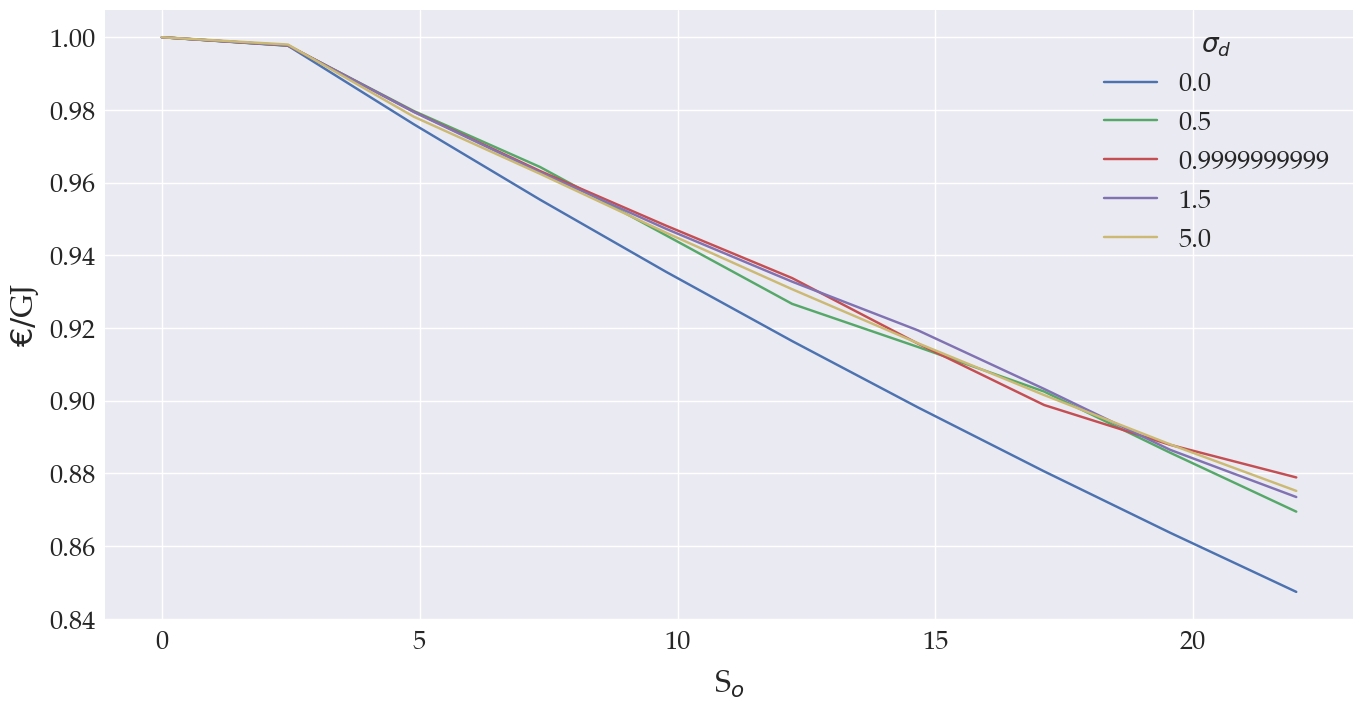

In [22]:
one_graph()
fig, ax = plt.subplots(1,1,figsize = (14,8))
df_results.xs(1,level='h')['p_index'].unstack('$\sigma_d$').plot(ax=ax,legend=True)
ax.set_xlabel(r'S$_o$', labelpad=10);
ax.set_ylabel(r'$€/$GJ', labelpad = 5);

fig.tight_layout();
fig.subplots_adjust(top=0.9);
if slides:
    fig.savefig(f"{out_folder}\\mBasicInt_Storage_PriceIndex_slides.pdf",facecolor='#FAFAFA',edgecolor='k')
else:
    fig.savefig(f"{out_folder}\\mBasicInt_Storage_PriceIndex.pdf",edgecolor='k')

*Plot demand:*

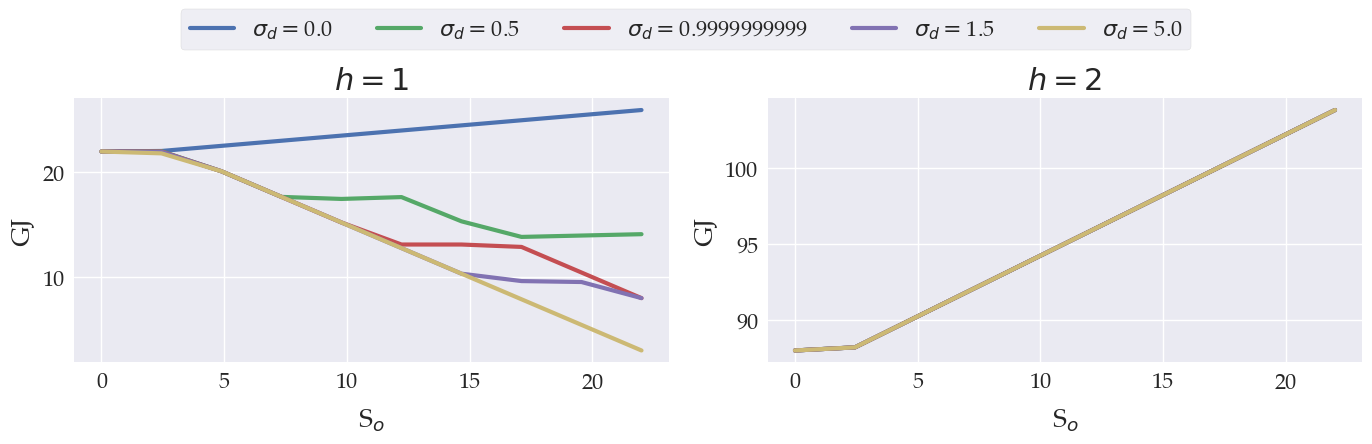

In [23]:
# %%capture
mult_graphs()
nplots = len(m.db['h'])
nrows = math.ceil(nplots/2)
fig,axes = plt.subplots(nrows,min(nplots,2),figsize=(14,(4*nrows)),sharey=False);
plt.subplots_adjust(hspace=0.35)
offset_N, offset_Arrow, offset_q = 1, 1, 3
for j in range(nplots):
    ax = plt.subplot(nrows,min(nplots,2),j+1)
    h = j+1
    
    df_results.xs(h,level='h')['D'].unstack('$\sigma_d$').plot(ax=ax,legend=False,linewidth=3)
    ax.set_xlabel(r'S$_o$', labelpad=10);
    ax.set_ylabel(r'GJ', labelpad = 5);
    ax.set_title(f"""$h={h}$""")
    
    
fig.legend(['$\sigma_d=$'+str(x) for x in df_results.index.get_level_values('$\sigma_d$').unique()],
           loc=9,ncol=len(df_results.index.get_level_values('$\sigma_d$').unique()),frameon=True,bbox_to_anchor=(0.5, 1.15))
fig.tight_layout();
fig.subplots_adjust(top=0.9);
if slides:
    fig.savefig(f"{out_folder}\\mBasicInt_Storage_DemandH_slides.pdf",facecolor='#FAFAFA',edgecolor='k')
else:
    fig.savefig(f"{out_folder}\\mBasicInt_Storage_DemandH.pdf",edgecolor='k')

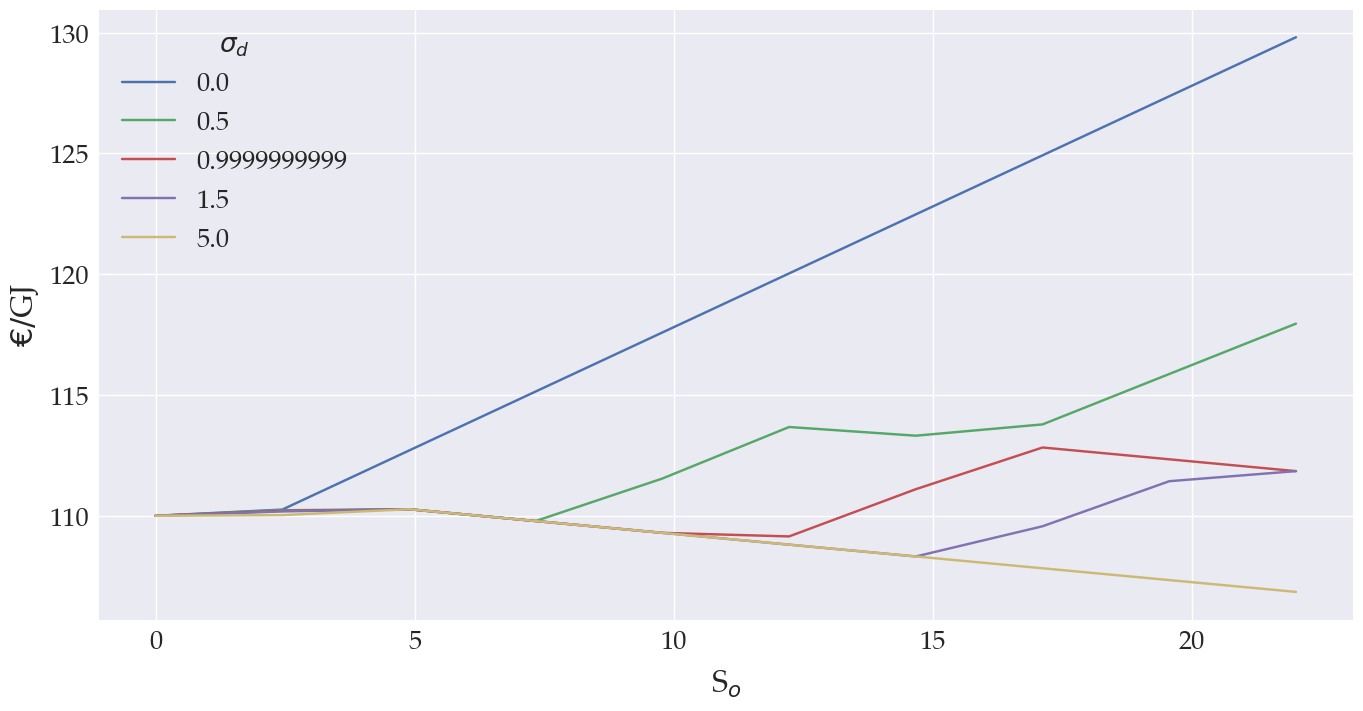

In [24]:
one_graph()
fig, ax = plt.subplots(1,1,figsize = (14,8))
df_results['D'].groupby(['$\sigma_d$','S$_0$']).agg('sum').unstack('$\sigma_d$').plot(ax=ax,legend=True)
ax.set_xlabel(r'S$_o$', labelpad=10);
ax.set_ylabel(r'$€/$GJ', labelpad = 5);

fig.tight_layout();
fig.subplots_adjust(top=0.9);
if slides:
    fig.savefig(f"{out_folder}\\mBasicInt_Storage_TotDemand_slides.pdf",facecolor='#FAFAFA',edgecolor='k')
else:
    fig.savefig(f"{out_folder}\\mBasicInt_Storage_TotDemand.pdf",edgecolor='k')

*Plot practical capacity factor:*

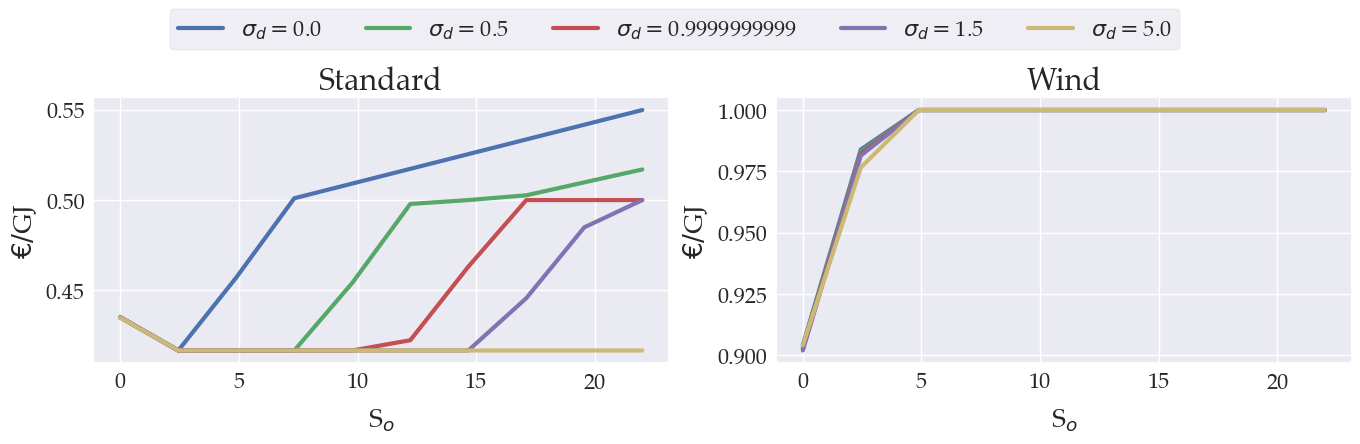

In [26]:
# %%capture
mult_graphs()
pt = [x for x in df_plants.index.get_level_values('Agent').unique() if x!='Solar PV']
nplots = len(pt)
nrows = math.ceil(nplots/2)
fig,axes = plt.subplots(nrows,min(nplots,2),figsize=(14,(4*nrows)),sharey=False);
plt.subplots_adjust(hspace=0.35)
offset_N, offset_Arrow, offset_q = 1, 1, 3
for j in range(nplots):
    ax = plt.subplot(nrows,min(nplots,2),j+1)
    agent = pt[j]
    
    df_plants.xs(agent,level='Agent')['PracticalCapacityFactor'].unstack('$\sigma_d$').plot(ax=ax,legend=False,linewidth=3)
    ax.set_xlabel(r'S$_o$', labelpad=10);
    ax.set_ylabel(r'$€/$GJ', labelpad = 5);
    ax.set_title(f"""{agent}""")
    
    
fig.legend(['$\sigma_d=$'+str(x) for x in df_plants.index.get_level_values('$\sigma_d$').unique()],
           loc=9,ncol=len(df_results.index.get_level_values('$\sigma_d$').unique()),frameon=True,bbox_to_anchor=(0.5, 1.15))
fig.tight_layout();
fig.subplots_adjust(top=0.9);
if slides:
    fig.savefig(f"{out_folder}\\mBasicInt_Storage_PCF_slides.pdf",facecolor='#FAFAFA',edgecolor='k')
else:
    fig.savefig(f"{out_folder}\\mBasicInt_Storage_PCF.pdf",edgecolor='k')

*Plot marginal values:*

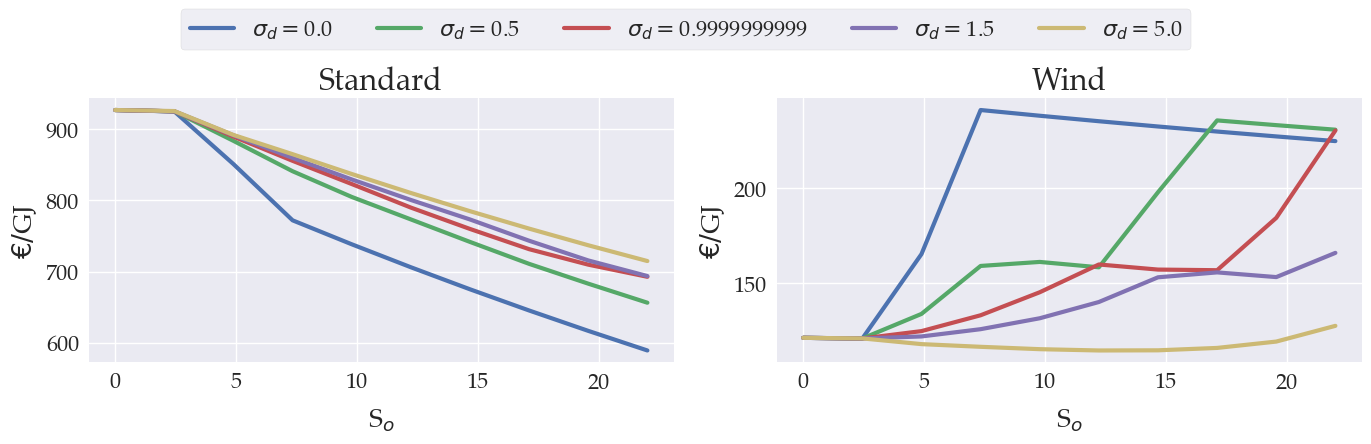

In [27]:
# %%capture
mult_graphs()
pt = [x for x in df_plants.index.get_level_values('Agent').unique() if x!='Solar PV']
nplots = len(pt)
nrows = math.ceil(nplots/2)
fig,axes = plt.subplots(nrows,min(nplots,2),figsize=(14,(4*nrows)),sharey=False);
plt.subplots_adjust(hspace=0.35)
offset_N, offset_Arrow, offset_q = 1, 1, 3
for j in range(nplots):
    ax = plt.subplot(nrows,min(nplots,2),j+1)
    agent = pt[j]
    
    df_plants.xs(agent,level='Agent')['marginalEconomicValue'].unstack('$\sigma_d$').plot(ax=ax,legend=False,linewidth=3)
    ax.set_xlabel(r'S$_o$', labelpad=10);
    ax.set_ylabel(r'$€/$GJ', labelpad = 5);
    ax.set_title(f"""{agent}""")
    
    
fig.legend(['$\sigma_d=$'+str(x) for x in df_plants.index.get_level_values('$\sigma_d$').unique()],
           loc=9,ncol=len(df_results.index.get_level_values('$\sigma_d$').unique()),frameon=True,bbox_to_anchor=(0.5, 1.15))
fig.tight_layout();
fig.subplots_adjust(top=0.9);
if slides:
    fig.savefig(f"{out_folder}\\mBasicInt_Storage_mEV_slides.pdf",facecolor='#FAFAFA',edgecolor='k')
else:
    fig.savefig(f"{out_folder}\\mBasicInt_Storage_mEV.pdf",edgecolor='k')

*Plot welfare:*

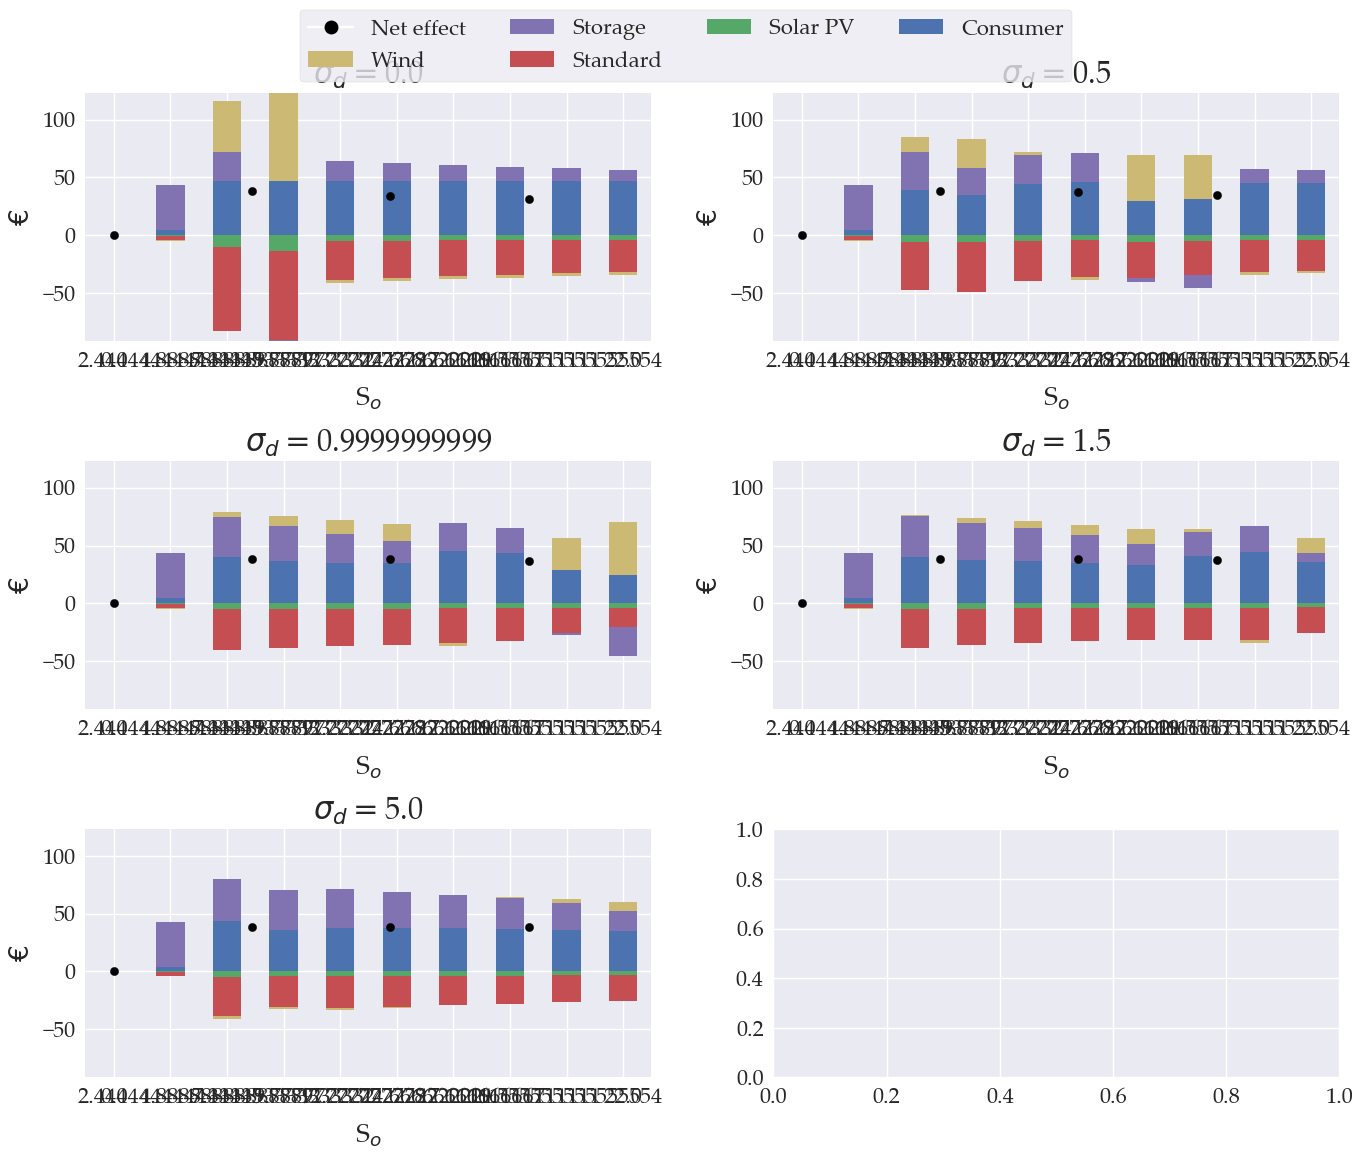

In [53]:
# Make Datafrmae
df_cs = I/df_results['p_index'].xs(1,level='h')
df_cs.index = pd.MultiIndex.from_tuples([(x,y,'Consumer') for x,y in zip(df_cs.index.get_level_values('$\sigma_d$'),df_cs.index.get_level_values('S$_0$'))],names=df_cs.index.names+['Agent'])
df_st = ((1-λ)*df_results['p'].xs(2,level='h')-df_results['p'].xs(1,level='h'))*df_results.xs(1,level='h').index.get_level_values('S$_0$')
df_st.index = pd.MultiIndex.from_tuples([(x,y,'Storage') for x,y in zip(df_st.index.get_level_values('$\sigma_d$'),df_st.index.get_level_values('S$_0$'))],names=df_st.index.names+['Agent'])
W = df_plants['Profits'].rename('W').append(df_cs.rename('W')).append(df_st.rename('W'))
W_neg, W_pos = W.groupby(['$\sigma_d$','Agent']).diff().clip(upper=0).unstack('Agent').fillna(0), W.groupby(['$\sigma_d$','Agent']).diff().clip(lower=0).unstack('Agent').fillna(0)

# %%capture
mult_graphs()
σ_d_grid = [x for x in W.index.get_level_values('$\sigma_d$').unique()]
nplots = len(σ_d_grid)
nrows = math.ceil(nplots/2)
fig,axes = plt.subplots(nrows,min(nplots,2),figsize=(14,(4*nrows)),sharey=False);
plt.subplots_adjust(hspace=0.35)
offset_N, offset_Arrow, offset_q = 1, 1, 3
for j in range(nplots):
    ax = plt.subplot(nrows,min(nplots,2),j+1)
    σ_d = σ_d_grid[j]
    
    W_pos.xs(σ_d,level='$\sigma_d$').plot.bar(ax=ax, stacked=True, linewidth=0.,legend=False)#, width=1.0)
    ax.set_prop_cycle(None)
    W_neg.xs(σ_d,level='$\sigma_d$').rename(columns=lambda x: '_' + x).plot.bar(ax=ax, stacked=True, linewidth=0.,legend=False)#, width=1.0)
    W.xs(σ_d,level='$\sigma_d$').groupby('S$_0$').agg('sum').diff().fillna(0).reset_index().plot.scatter(ax=ax,x='S$_0$',y='W',color='black',s=35,marker='o')

    
    ax.set_xlabel(r'S$_o$', labelpad=10)
    ax.set_ylabel(r'$€$',labelpad=5)
    ax.set_ylim([W_neg.sum(axis=1).min(),W_pos.sum(axis=1).max()])
    ax.set_title(f"""$\sigma_d=${σ_d}""")
    
    
# fig.legend(['$\sigma_d=$'+str(x) for x in df_plants.index.get_level_values('$\sigma_d$').unique()],
#            loc=9,ncol=len(df_results.index.get_level_values('$\sigma_d$').unique()),frameon=True,bbox_to_anchor=(0.5, 1.15))
legend_elements = [mpl.lines.Line2D([0], [0], marker='o',color='w', label='Net effect',markerfacecolor='black', markersize=10),
                   mpl.patches.Patch(facecolor=colors[4], edgecolor=None, label='Wind'),
                   mpl.patches.Patch(facecolor=colors[3], edgecolor=None, label='Storage'),
                   mpl.patches.Patch(facecolor=colors[2], edgecolor=None, label='Standard'),
                   mpl.patches.Patch(facecolor=colors[1], edgecolor=None, label='Solar PV'),
                   mpl.patches.Patch(facecolor=colors[0], edgecolor=None, label='Consumer')]
fig.legend(handles=legend_elements, loc='lower center', ncol=4, frameon=True, bbox_to_anchor=(0.5, 0.9))
fig.tight_layout();
fig.subplots_adjust(top=0.9);
if slides:
    fig.savefig(f"{out_folder}\\mBasicInt_Storage_Welfare_slides.pdf",facecolor='#FAFAFA',edgecolor='k')
else:
    fig.savefig(f"{out_folder}\\mBasicInt_Storage_Welfare.pdf",edgecolor='k')

122.97927307646637

In [ ]:
W_neg.min()

NameError: name 'W_pos' is not defined

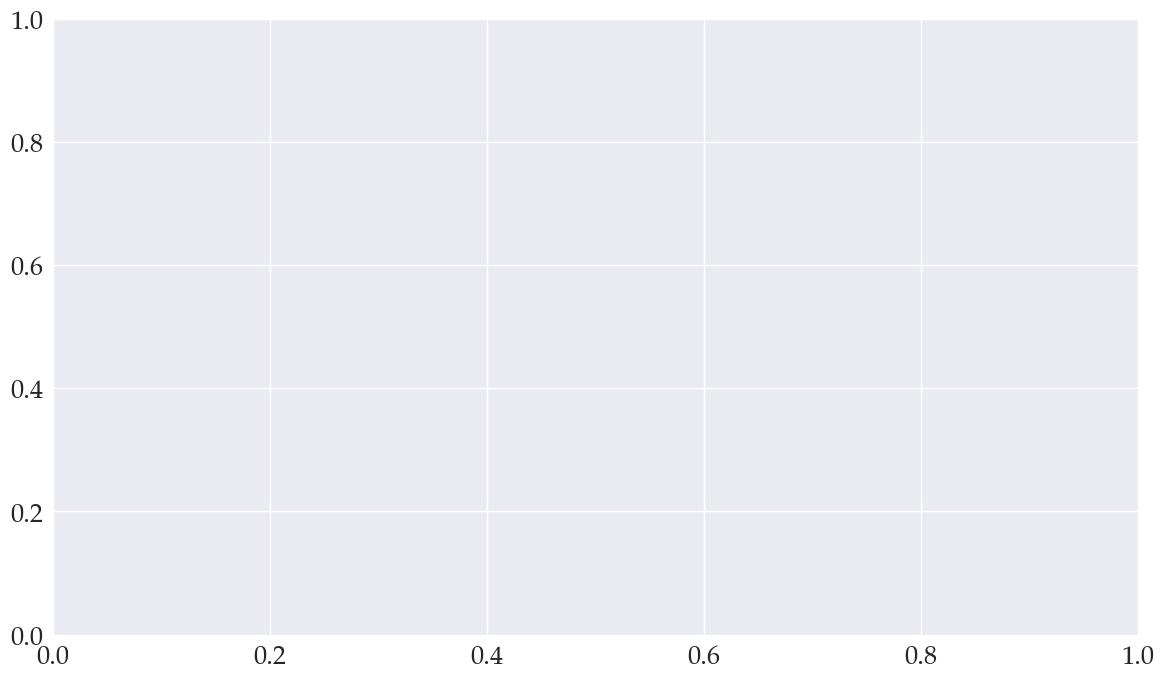

In [58]:
one_graph()
fig, ax = plt.subplots(1,1,figsize = (14,8))
W_pos.plot.bar(ax=ax, stacked=True, linewidth=0.,legend=False)#, width=1.0)
ax.set_prop_cycle(None)
W_neg.rename(columns=lambda x: '_' + x).plot.bar(ax=ax, stacked=True, linewidth=0.,legend=False)#, width=1.0)
W.groupby('loop').agg('sum').diff().fillna(0).reset_index().plot.scatter(ax=ax,x='loop',y='W',color='black',s=35,marker='o')

# Axes
ax.set_ylim([W_neg.sum(axis=1).min()*1.5, W_pos.sum(axis=1).max()*1.1])
ax.set_xticks(loop,labels=(step.cumsum()*db['Load']).astype(float).values.round(1))
ax.set_xlabel(r'S$_o$', labelpad=10)
ax.set_ylabel(r'$€$',labelpad=5)

# General
legend_elements = [mpl.lines.Line2D([0], [0], marker='o',color='w', label='Net effect',markerfacecolor='black', markersize=10),
                   mpl.patches.Patch(facecolor=colors[4], edgecolor=None, label='Wind'),
                   mpl.patches.Patch(facecolor=colors[3], edgecolor=None, label='Storage'),
                   mpl.patches.Patch(facecolor=colors[2], edgecolor=None, label='Standard'),
                   mpl.patches.Patch(facecolor=colors[1], edgecolor=None, label='Solar PV'),
                   mpl.patches.Patch(facecolor=colors[0], edgecolor=None, label='Consumer')]
fig.legend(handles=legend_elements, loc='lower center', ncol=4, frameon=True, bbox_to_anchor=(0.5, 0.9))
fig.tight_layout();
fig.subplots_adjust(top=0.9);

*Plot welfare:*

In [ ]:
# Producers
p = solution['marginalSystemCosts']
E = solution['Generation']
R = p*E
mc = db['mc']
VC = mc*E
fom = db['FOM']*1000*len(db['h'])/8760
FOM = fom*db['GeneratingCapacity']
id2tech = {x[0]:x[1] for x in db['id2tech']}
Π = (R-VC-FOM).groupby(['loop','id']).agg('sum').rename(id2tech,level='id').groupby(['loop','id']).agg('sum').rename_axis(['loop','agent']).rename('W')

# Consumers
Δp = db['MWP_LoadShedding']-p
S0 = (step.cumsum()*db['Load']).astype(float).droplevel('c')
L = solution['HourlyDemand']-S0
v = (Δp*L).groupby('loop').agg('sum').to_frame().assign(agent='Consumer').set_index('agent',append=True)[0].rename('W')

# Storage
π = p.unstack('h')
π['diff'] = (1-λ)*π[2]-π[1]
π = (π['diff']*S0.droplevel('h')).to_frame().assign(agent='Storage').set_index('agent',append=True)[0].rename('W')
# Combine dataframe
W = Π.append(v).append(π).sort_index()
W_neg, W_pos = W.groupby('agent').diff().clip(upper=0).unstack('agent').fillna(0), W.groupby('agent').diff().clip(lower=0).unstack('agent').fillna(0)

In [ ]:
one_graph()
fig, ax = plt.subplots(1,1,figsize = (14,8))
W_pos.plot.bar(ax=ax, stacked=True, linewidth=0.,legend=False)#, width=1.0)
ax.set_prop_cycle(None)
W_neg.rename(columns=lambda x: '_' + x).plot.bar(ax=ax, stacked=True, linewidth=0.,legend=False)#, width=1.0)
W.groupby('loop').agg('sum').diff().fillna(0).reset_index().plot.scatter(ax=ax,x='loop',y='W',color='black',s=35,marker='o')

# Axes
ax.set_ylim([W_neg.sum(axis=1).min()*1.5, W_pos.sum(axis=1).max()*1.1])
ax.set_xticks(loop,labels=(step.cumsum()*db['Load']).astype(float).values.round(1))
ax.set_xlabel(r'S$_o$', labelpad=10)
ax.set_ylabel(r'$€$',labelpad=5)

# General
legend_elements = [mpl.lines.Line2D([0], [0], marker='o',color='w', label='Net effect',markerfacecolor='black', markersize=10),
                   mpl.patches.Patch(facecolor=colors[4], edgecolor=None, label='Wind'),
                   mpl.patches.Patch(facecolor=colors[3], edgecolor=None, label='Storage'),
                   mpl.patches.Patch(facecolor=colors[2], edgecolor=None, label='Standard'),
                   mpl.patches.Patch(facecolor=colors[1], edgecolor=None, label='Solar PV'),
                   mpl.patches.Patch(facecolor=colors[0], edgecolor=None, label='Consumer')]
fig.legend(handles=legend_elements, loc='lower center', ncol=4, frameon=True, bbox_to_anchor=(0.5, 0.9))
fig.tight_layout();
fig.subplots_adjust(top=0.9);